In [281]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
import pickle
import os
from datetime import datetime
import math

In [282]:
with open("processed_datasets.pkl", "rb") as file: # save file as pickle to use in other notebooks
    prcessed_datasets = pickle.load(file)

In [283]:
prcessed_datasets.keys()

dict_keys(['cat', 'rabbit', 'bus'])

In [284]:
# Function to create a base diffusion model
def diffusion_model(input_dim=3, embedding_dim=512, hidden_dim=1024, num_categories=3, num_layers=3, dropout=0.1):
    # Stroke embedder: [x, y, pen_state] -> embedding
    stroke_embedder = nn.Sequential(
        nn.Linear(input_dim, 128),
        nn.ReLU(),
        nn.Linear(128, 256),
        nn.ReLU(), 
        nn.Linear(256, embedding_dim),
        nn.ReLU()
    )
    
    # Category embedder: category_id -> embedding  
    category_embedder = nn.Embedding(num_categories, embedding_dim)
    
    # Temporal encoder: LSTM for sequence modeling
    temporal_encoder = nn.LSTM(
        input_size=embedding_dim,
        hidden_size=hidden_dim,
        num_layers=num_layers,
        batch_first=True,
        dropout=dropout if num_layers > 1 else 0
    )
    
    # Self attention layer 
    attention_layer = nn.MultiheadAttention(
        embed_dim=hidden_dim,
        num_heads=8,
        dropout=0.1,
        batch_first=True
    )
    
    # Noise predictor: hidden_states -> predicted_noise
    noise_predictor = nn.Sequential(
        nn.Linear(hidden_dim, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128), 
        nn.ReLU(),
        nn.Linear(128, input_dim)
    )
    
    model_components = {
        'stroke_embedder': stroke_embedder,
        'category_embedder': category_embedder, 
        'temporal_encoder': temporal_encoder,
        'attention_layer': attention_layer,
        'noise_predictor': noise_predictor
    }
    
    return model_components

In [285]:
prcessed_datasets['bus']['train_data'].shape

(10000, 451, 3)

In [286]:
def model_forward_training(sequences, model_components, categories, timesteps):
    # Get components
    stroke_embedder = model_components['stroke_embedder']
    category_embedder = model_components['category_embedder']
    temporal_encoder = model_components['temporal_encoder']
    attention_layer = model_components['attention_layer']
    noise_predictor = model_components['noise_predictor']
    
    batch_size, seq_len, _ = sequences.shape
    
    # Embded stroke sequences
    stroke_embeddings = stroke_embedder(sequences) # [batch, seq_len, embedding_dim]
    
    # Embed categories and inject into sequence
    category_embeddings = category_embedder(categories)  # [batch, embedding_dim]
    category_expanded = category_embeddings.unsqueeze(1).expand(-1, seq_len, -1)
    
    # Combine stroke and category embeddings
    conditioned_embeddings = stroke_embeddings + category_expanded
    
    # Process through LSTM
    lstm_output, _ = temporal_encoder(conditioned_embeddings)  # [batch, seq_len, hidden_dim]
    
    # Apply self attention
    attended_output, _ = attention_layer(lstm_output, lstm_output, lstm_output)
    
    # Predict noise
    predicted_noise = noise_predictor(attended_output)
    
    return predicted_noise

In [313]:
# Create progressive noise schedule for diffusion
def create_noise_schedule(timesteps=500):
    s = 0.008  # Small offset
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    
    # Cosine schedule formula
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]  # Normalize
    
    # Calculate betas from alphas
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    betas = torch.clip(betas, 0.0001, 0.9999)  # Clamp for stability
    
    alphas = 1 - betas
     
    noise_schedule = {
        'betas': betas,
        'alphas': alphas,
        'alphas_cumprod': alphas_cumprod,
        'timesteps': timesteps
    }
    
    return noise_schedule

In [288]:
def noise_addition(sequences, noise, timesteps, noise_schedule):
    alphas_cumprod = noise_schedule['alphas_cumprod']
    
    # Get alpha values for each timestep in batch
    alpha_t = alphas_cumprod[timesteps].view(-1, 1, 1)  # [batch, 1, 1]
    
    # Only add noise to coordinates [x, y], keep pen_state [2] unchanged
    noisy_sequences = sequences.clone()
    
    # Add noise to x and y coordinates
    noisy_sequences[:, :, :2] = torch.sqrt(alpha_t) * sequences[:, :, :2] + torch.sqrt(1 - alpha_t) * noise[:, :, :2] # Keep pen_state unchanged (no noise on pen_state) noisy_sequences[:, :, 2] remains the same
    
    return noisy_sequences

In [289]:
# Compute weighted loss for diffusion traning
def compute_weigthed_loss(predicted_noise, target_noise, sequences):
    # Basic MSE loss
    mse_loss = F.mse_loss(predicted_noise, target_noise, reduction='none')
    
    # Create weights based on stroke changes
    pen_states = sequences[:, :, 2]  # [batch, seq_len]
    
    # Higher weight for stroke boundaries
    pen_change_weight = torch.ones_like(pen_states)
    
    # Find stroke changes
    pen_changes = torch.abs(pen_states[:, 1:] - pen_states[:, :-1]) > 0.5
    pen_change_weight[:, 1:][pen_changes] = 2.0 
    
    # Apply weights to coordinates only
    weights = torch.ones_like(mse_loss)
    weights[:, :, :2] = pen_change_weight.unsqueeze(-1).expand(-1, -1, 2)
    
    # Weighted loss calculation
    weighted_loss = (mse_loss * weights).mean()
    
    return weighted_loss

In [ ]:
def create_dataloader(dataset, batch_size=32):
    category_mapping = {
    'cat': 0,
    'bus': 1, 
    'rabbit': 2
    }
    
    category_name = dataset['category']
    category_id = category_mapping[category_name]
    
    # Get data
    train_data = dataset['train_data']
    test_data = dataset['test_data']
    
    # Convert train data to torch
    train_sequences = torch.FloatTensor(train_data)
    train_categories = torch.full((len(train_data),), category_id, dtype=torch.long)
    
    # Convert test data to torch
    test_sequences = torch.FloatTensor(test_data)
    test_categories = torch.full((len(test_data),), category_id, dtype=torch.long)
    
    # Create datasets
    train_dataset = TensorDataset(train_sequences, train_categories)
    test_dataset = TensorDataset(test_sequences, test_categories)
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"Train: {len(train_dataset)} samples, {len(train_loader)} batches")
    print(f"Test: {len(test_dataset)} samples, {len(test_loader)} batches")
    
    return train_loader, test_loader

In [291]:
bus_train_loader, bus_test_loader = create_dataloader(prcessed_datasets['bus'])

Train: 10000 samples, 1250 batches
Test: 2000 samples, 250 batches


In [292]:
# Setup device
def setup_device():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    return device

In [308]:
# Setup adam optimizer
def initialize_optimizer(model_components, lr, num_epochs):
    # Collect all parameters from all components
    all_params = []
    total_params = 0
    
    for _, component in model_components.items():
        component_params = list(component.parameters())
        all_params.extend(component_params)
        num_params = sum(p.numel() for p in component_params)
        total_params += num_params
    
    # Create optimizer
    optimizer = torch.optim.Adam(all_params, lr=lr)
    
    # Learning decay scheduler
    scheduler = create_lr_scheduler(optimizer, num_epochs, warmup_epochs=10)
    
    print(f"Total parameters: {total_params:,}")
    print(f"Learning rate: {lr}")
    
    return optimizer, scheduler, all_params, total_params

In [305]:
# Helper function to train the model one epochs
def train_one_epoch(model_components, dataloader, noise_schedule, optimizer, device, all_params):
    # Set parameters
    total_loss = 0
    num_batches = 0
    
    # Set models to training mode
    for component in model_components.values():
        component.train()
    
    for batch_idx, (sequences, categories) in enumerate(tqdm(dataloader, desc="Training")):
        
        # Move data to device
        sequences = sequences.to(device)
        categories = categories.to(device)
        batch_size = sequences.shape[0]
        
        # Sample random timesteps for diffusion
        timesteps = torch.randint(0, noise_schedule['timesteps'], (batch_size,), device=device)
        
        # Generate noise (only for coordinates, not stroke state)
        noise = torch.randn_like(sequences, device=device)
        noise[:, :, 2] = 0  # No noise on stroke state
        
        # Add progressive noise to sequences
        noisy_sequences = noise_addition(sequences, noise, timesteps, noise_schedule)
        
        # Forward pass through model
        predicted_noise = model_forward_training(noisy_sequences, model_components, categories, timesteps)
        
        # Compute weighted loss
        loss = compute_weigthed_loss(predicted_noise, noise, sequences)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(all_params, max_norm=1.0)
        
        # Gradient clipping
        all_params = [p for component in model_components.values() for p in component.parameters()]
        torch.nn.utils.clip_grad_norm_(all_params, max_norm=1.0)
        
        optimizer.step()
        
        # Track loss
        total_loss += loss.item()
        num_batches += 1
        
        # Print progress every 20 batches
        if batch_idx % 500 == 0:
            print(f"Batch {batch_idx:3d}: Loss = {loss.item():.4f}")
    
    # Calculate average loss
    avg_loss = total_loss / num_batches if num_batches > 0 else 0
    print(f"Epoch completed: Average Loss = {avg_loss:.4f}")
    
    return avg_loss

In [296]:
def save_model_complete(model_components, noise_schedule, loss_history, num_epochs, learning_rate, total_params, category_name, save_path="./models"):
    # Create save directory
    os.makedirs(save_path, exist_ok=True)
    
    # Create filename with timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_filename = f"sketch_diffusion_{category_name}_{timestamp}.pth"
    model_path = os.path.join(save_path, model_filename)
    
    save_dict = {
        'model_components': model_components,
        'noise_schedule': noise_schedule,
        'loss_history': loss_history,
        'training_info': {
            'num_epochs': num_epochs,
            'learning_rate': learning_rate,
            'final_loss': loss_history[-1] if loss_history else 0,
            'best_loss': min(loss_history) if loss_history else 0,
            'category': category_name,
            'total_parameters': total_params,
            'timestamp': timestamp
        }
    }
    
    # Save model
    torch.save(save_dict, model_path)
    
    print(f"Complete model saved to: {model_path}")
    print(f"Final loss: {loss_history[-1]:.4f}")
    print(f"Best loss: {min(loss_history):.4f}")
    print(f"Category: {category_name}")
    
    return model_path

In [297]:
# Learning decay scheduler
def create_lr_scheduler(optimizer, num_epochs, warmup_epochs=10):
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            # Warmup: gradually increase LR
            return epoch / warmup_epochs
        else:
            # Cosine decay after warmup
            progress = (epoch - warmup_epochs) / (num_epochs - warmup_epochs)
            return 0.5 * (1 + math.cos(math.pi * progress))
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    return scheduler

In [312]:
# Full traning loop to train model
def train_model(model_components, dataloader, num_epochs=50, learning_rate=1e-4, save_path="./models"):
    print("STARTING TRAINING")
    print(f"Epochs: {num_epochs}")
    print(f"Learning rate: {learning_rate}")
    print(f"Batches per epoch: {len(dataloader)}")
    
    # Initialize noise scheduler
    noise_schedule = create_noise_schedule(timesteps=1000)
    
    # Initialize device
    device = setup_device()
    if device.type == 'cuda':
        print(f"GPU: {torch.cuda.get_device_name()}")
        
    # Move models to device
    for name, component in model_components.items():
        model_components[name] = component.to(device)
    
    # Move noise schedule to device
    for key, value in noise_schedule.items():
        if isinstance(value, torch.Tensor):
            noise_schedule[key] = value.to(device)
    
    # Initialize adam optimizer
    optimizer, scheduler, all_params, total_params = initialize_optimizer(model_components, learning_rate, num_epochs)
    
    print("\nSTARTING TRAINING LOOP")
    loss_history = []
    
    for epoch in range(num_epochs):
        print(f"\nEPOCH {epoch + 1}/{num_epochs}")
        
        # Train one epoch
        avg_loss = train_one_epoch(model_components, dataloader, noise_schedule, optimizer, device, all_params)
        loss_history.append(avg_loss)
        scheduler.step()
        
        current_lr = scheduler.get_last_lr()[0]
        print(f"Loss: {avg_loss:.4f} | LR: {current_lr:.2e}")
        
        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            print(f"Checkpoint at epoch {epoch + 1}")
    
    # Create save directory
    os.makedirs(save_path, exist_ok=True)
    
    # Get first batch to determine category
    first_batch = next(iter(dataloader))
    category_id = first_batch[1][0].item()
    category_names = {0: 'cat', 1: 'bus', 2: 'rabbit'}
    category_name = category_names.get(category_id, f'category_{category_id}')
    
    model_path = save_model_complete(
        model_components=model_components,
        noise_schedule=noise_schedule,
        loss_history=loss_history,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        total_params=total_params,
        category_name=category_name,
        save_path=save_path
    )
    
    print(f"Model saved to: {model_path}")
    print(f"Final loss: {loss_history[-1]:.4f}")
    print(f"Best loss: {min(loss_history):.4f}")
    print(f"Category: {category_name}")

    return model_components, loss_history

In [299]:
def plot_training_loss(loss_history):
    print("\nPLOTTING TRAINING LOSS")
    
    plt.figure(figsize=(10, 6))
    
    # Plot loss
    epochs = range(1, len(loss_history) + 1)
    plt.plot(epochs, loss_history, 'b-', linewidth=2, marker='o', markersize=6)
    
    # Formatting
    plt.title('Training Loss Over Epochs', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add loss values on points
    for i, loss in enumerate(loss_history):
        plt.annotate(f'{loss:.4f}', (i+1, loss), textcoords="offset points", 
                    xytext=(0,10), ha='center', fontsize=9)
    
    # Add statistics
    final_loss = loss_history[-1]
    best_loss = min(loss_history)
    best_epoch = loss_history.index(best_loss) + 1
    
    plt.text(0.02, 0.98, f'Final Loss: {final_loss:.4f}\nBest Loss: {best_loss:.4f} (Epoch {best_epoch})',
             transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print("Training Summary:")
    print(f"Total epochs: {len(loss_history)}")
    print(f"Final loss: {final_loss:.4f}")
    print(f"Best loss: {best_loss:.4f} (Epoch {best_epoch})")
    print(f"Loss improvement: {((loss_history[0] - final_loss) / loss_history[0] * 100):.1f}%")

In [300]:
model_components = diffusion_model()

In [311]:
trained_model, loss_history = train_model(
        model_components=model_components,
        dataloader=bus_train_loader,
        learning_rate=1e-4,
        save_path="./models")

STARTING TRAINING
Epochs: 300
Learning rate: 0.0001
Batches per epoch: 1250
Total parameters: 28,147,715
Learning rate: 0.0001

STARTING TRAINING LOOP

EPOCH 1/300


Training:   0%|          | 0/1250 [00:00<?, ?it/s]

Training:   0%|          | 1/1250 [00:05<1:50:56,  5.33s/it]

Batch   0: Loss = 0.7079


Training:  13%|█▎        | 165/1250 [11:09<1:13:24,  4.06s/it]


KeyboardInterrupt: 


PLOTTING TRAINING LOSS
Plot saved as 'training_loss.png'


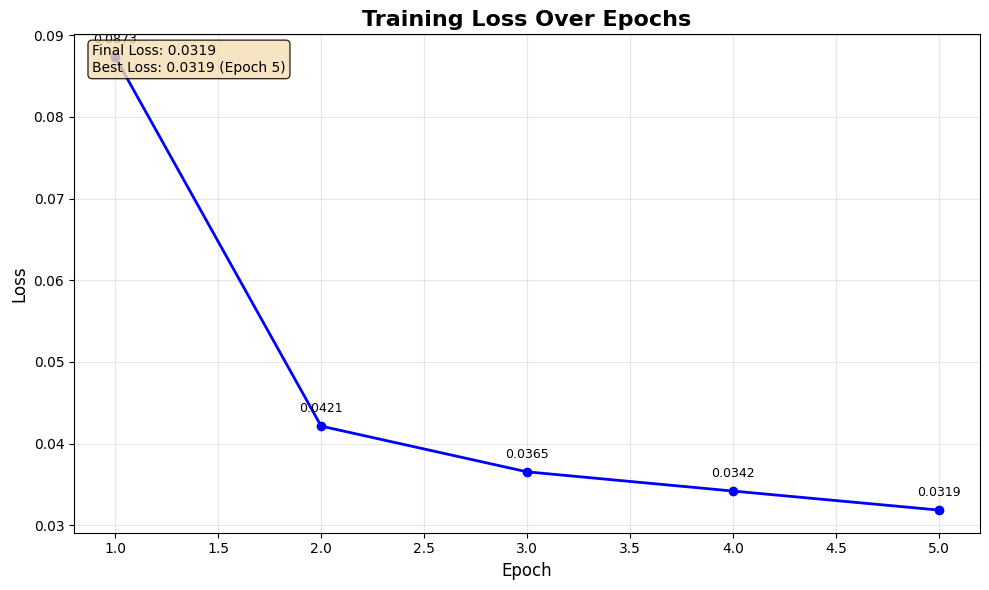

Training Summary:
Total epochs: 5
Final loss: 0.0319
Best loss: 0.0319 (Epoch 5)
Loss improvement: 63.5%


In [237]:
plot_training_loss(loss_history)

In [246]:
def generate_simple_sketch(trained_model, category_id, seq_len, num_steps=50):
    device = setup_device()
    for component in trained_model.values():
        component.eval()
    
    # Start with random noise
    sketch = torch.randn(1, seq_len, 3, device=device)
    
    # Set pen states to reasonable values
    sketch[0, :, 2] = 1.0  # Start with pen down
    
    # Category for conditioning
    category = torch.tensor([category_id], device=device)
    
    with torch.no_grad():
        # Simple denoising loop
        for step in range(num_steps):
            # Current timestep (going from high noise to low noise)
            t = torch.tensor([num_steps - step - 1], device=device)
            
            # Predict noise using your model
            predicted_noise = model_forward_training(sketch, trained_model, category, t)
            
            # Simple denoising step - remove some predicted noise
            noise_scale = 0.02 * (num_steps - step) / num_steps
            sketch[:, :, :2] = sketch[:, :, :2] - noise_scale * predicted_noise[:, :, :2]
            
            # Keep pen states reasonable
            sketch[:, :, 2] = torch.clamp(sketch[:, :, 2], 0, 3)
    
    return sketch[0].cpu().numpy()

In [257]:
def generate_sketch_steps(trained_model, category_id, seq_len, num_steps=20):
    print("Generating step-by-step sketch...")
    steps = []

    device = setup_device()
    
    # Set models to eval
    for component in trained_model.values():
        component.eval()
    
    # Start with random noise
    sketch = torch.randn(1, seq_len, 3, device=device)
    sketch[0, :, 2] = 1.0
    
    category = torch.tensor([category_id], device=device)
    
    with torch.no_grad():
        # Save initial noise
        steps.append(sketch[0].cpu().numpy().copy())
        
        for step in range(num_steps):
            t = torch.tensor([num_steps - step - 1], device=device)
            
            # Predict and remove noise
            predicted_noise = model_forward_training(sketch, trained_model, category, t)
            noise_scale = 0.02 * (num_steps - step) / num_steps
            sketch[:, :, :2] = sketch[:, :, :2] - noise_scale * predicted_noise[:, :, :2]
            sketch[:, :, 2] = torch.clamp(sketch[:, :, 2], 0, 3)
            
            # Save this step
            steps.append(sketch[0].cpu().numpy().copy())
    
    print(f"Generated {len(steps)} steps")
    return steps

In [253]:
def create_generation_gif(steps, category_id, save_path="generation.gif", duration=100):
    print(f"Creating GIF with {len(steps)} frames...")
    category_name = ['Cat', 'Bus', 'Rabbit'][category_id]
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    def animate(frame):
        ax.clear()
        
        sketch = steps[frame]
        x, y, pen = sketch[:, 0], sketch[:, 1], sketch[:, 2]
        
        # Draw strokes up to current frame
        stroke_x, stroke_y = [], []
        
        for i in range(len(sketch)):
            if pen[i] > 0.5:
                stroke_x.append(x[i])
                stroke_y.append(y[i])
            else:
                if len(stroke_x) > 1:
                    ax.plot(stroke_x, stroke_y, 'b-', linewidth=2)
                stroke_x, stroke_y = [], []
        
        if len(stroke_x) > 1:
            ax.plot(stroke_x, stroke_y, 'b-', linewidth=2)
        
        ax.set_title(f'Generating {category_name} - Step {frame+1}/{len(steps)}', fontsize=16)
        ax.set_xlim(-1.2, 1.2)
        ax.set_ylim(-1.2, 1.2)
        ax.invert_yaxis()
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
    
    # Create animation
    anim = FuncAnimation(fig, animate, frames=len(steps), interval=duration, repeat=True)
    
    # Save GIF
    anim.save(save_path, writer='pillow', fps=1000//duration)
    plt.close()
    
    print(f"GIF saved as: {save_path}")

In [247]:
# Helper function to sketch the output
def plot_sketch(sketch, title="Generated Sketch"):
    plt.figure(figsize=(8, 8))
    
    # Extract coordinates
    x = sketch[:, 0]
    y = sketch[:, 1]
    pen = sketch[:, 2]
    
    # Draw strokes
    stroke_x, stroke_y = [], []
    
    for i in range(len(sketch)):
        if pen[i] > 0.5:  # pen down
            stroke_x.append(x[i])
            stroke_y.append(y[i])
        else:  # pen up - draw current stroke
            if len(stroke_x) > 1:
                plt.plot(stroke_x, stroke_y, 'b-', linewidth=2)
            stroke_x, stroke_y = [], []
    
    # Draw final stroke
    if len(stroke_x) > 1:
        plt.plot(stroke_x, stroke_y, 'b-', linewidth=2)
    
    plt.title(title, fontsize=16)
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.xlim(-1.2, 1.2)
    plt.ylim(-1.2, 1.2)
    plt.gca().invert_yaxis()
    plt.show()

In [255]:
def quick_generate_bus(trained_model, seq_len=451):
    sketch = generate_simple_sketch(trained_model, 1, seq_len)
    plot_sketch(sketch, "Generated Bus")

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


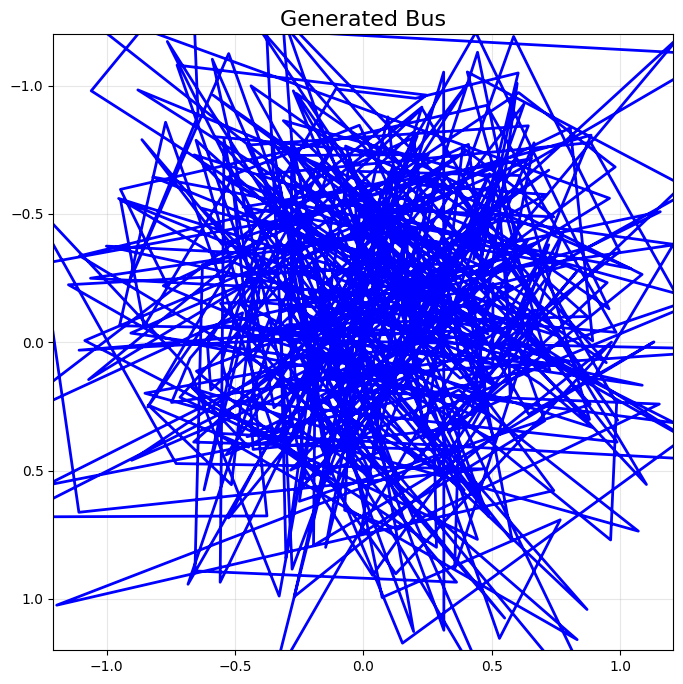

In [256]:
quick_generate_bus(trained_model, seq_len=451)

In [260]:
steps = generate_sketch_steps(trained_model, category_id=1 ,seq_len=451)
create_generation_gif(steps, 1)

Generating step-by-step sketch...
Generated 21 steps
Creating GIF with 21 frames...
GIF saved as: generation.gif
